# 0. Define functions and import packages

In [209]:
import pandas as pd
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
plt.style.use('seaborn-dark-palette')
from scipy import stats

import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

import plotly
import plotly.express as px
doc_units = pd.read_excel("../../data/processed/units.xlsx")
doc_dict = dict(zip(doc_units["from"],doc_units["to"])) 

/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_2068/3737874019.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heejinchae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vectorizor

In [210]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Tokenizer

In [211]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [212]:
def things_to_unit(a):
    "if 0.5km kind of that appears, convert to unitLength etc"
    for from_ in doc_dict:
        idx = np.where(
                 np.char.count(a,from_)==1
              )
        a[idx] = doc_dict[from_] 
    return a

In [213]:
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                continue
            if (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
                
        return val

In [214]:
class LemmaPlaceTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                val.append("unitN")
            elif (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
        new_val = np.array(val)
        new_val = np.apply_along_axis(things_to_unit, 0, new_val)
        return new_val

## Pre processor

In [215]:
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words & numbrs
    words = [word for word in words if word not in stopwords.words("english") or not word.isdigit()]


    # join words to make sentence
    document = " ".join(words)
    
    return document

## Let's see what are stop word

## Load data

In [216]:
df = pd.read_excel("../../data/raw/DataCorpus_classfied_중분류_2차 연구.xlsx")

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [217]:
def add_type_column(df):
    ops = df.iloc[:, 5:-3]
    print(ops.info())
    op_type = ops[ops.columns[1:]].apply(
        lambda x: ','.join(x.dropna().astype(str)),
        axis=1
    )
    op_type=op_type.str.lower()
    df["op_type"] = op_type
    op_type = pd.DataFrame(op_type.unique(), columns=["op_type"]).sort_values(
        by="op_type",
        key=lambda x: x.str.len(),
        ignore_index=True
        )
    op_type["op_id"] = op_type.index
    op_type.to_excel("../../data/processed/op_type.xlsx")
    df = df.merge(op_type, how='left', on="op_type")
    df.to_excel("../../data/processed/corpora_w_op_type.xlsx")
    return df

In [218]:
df = add_type_column(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Question type  227 non-null    object
 1   ordinary1      227 non-null    object
 2   ordinary2      215 non-null    object
 3   ordinary3      182 non-null    object
 4   ordinary4      102 non-null    object
 5   ordinary5      56 non-null     object
 6   ordinary6      27 non-null     object
 7   ordinary7      13 non-null     object
 8   ordinary8      3 non-null      object
 9   ordinary9      3 non-null      object
 10  ordinary10     2 non-null      object
 11  ordinary103    1 non-null      object
 12  ordinary102    1 non-null      object
 13  ordinary11     1 non-null      object
dtypes: object(14)
memory usage: 25.0+ KB
None


# 1. Type count from raw data
 Visualize initail labelled data

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


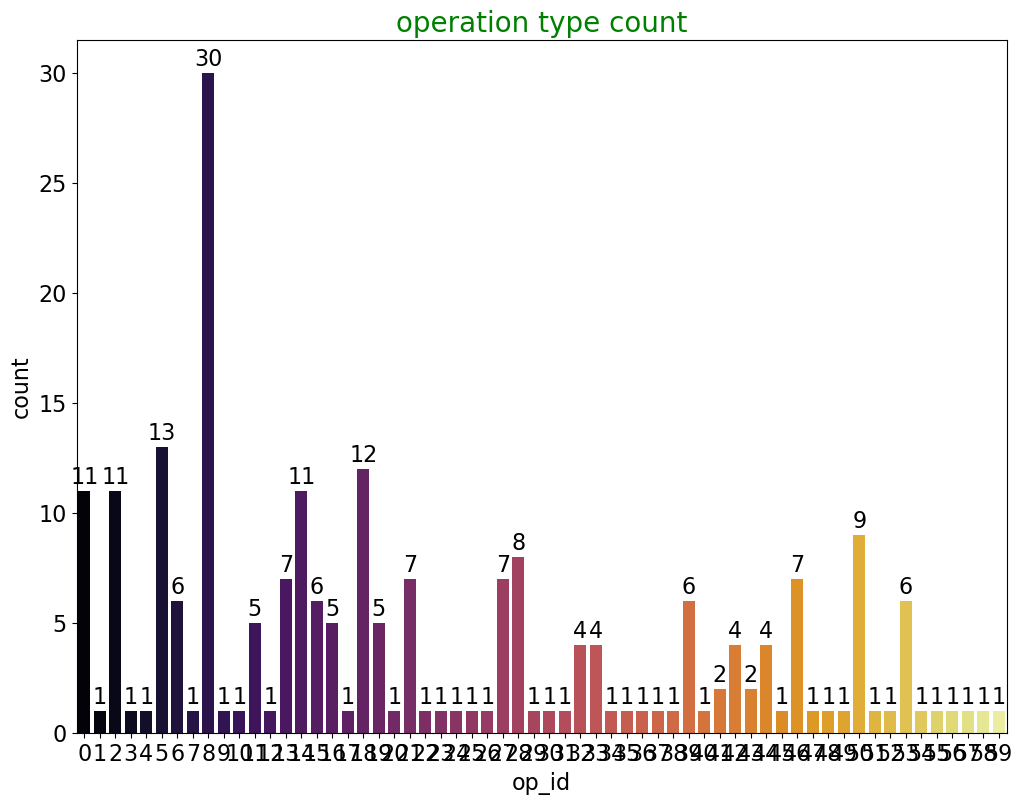

In [219]:
plt.figure(figsize=[12,9])
plot = sns.countplot(df["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
#plt.xticks(rotation=90)
plt.savefig("../../figures/class_and_count_initial.png", bbox_inches='tight')
plt.show()

# 2. Drop classes only with a value
 If a data is the only one in category, dropped <br />
 클래스에 해당하는 데이터가 n개 인것은 제거하기로 함. 여기서는 2개 이상으로 설정했음
 

In [220]:
df_drop_solo= df.groupby("op_id").filter(lambda x: len(x) >2)
df_drop_solo.to_excel("../../data/processed/corpora_unique_ops_dropped_wo_paraph.xlsx")
# Here paraphrase and import again
df_drop_solo = pd.read_excel("../../data/processed/train_test_only_paraphrased.xlsx")

In [221]:
df_drop_solo = df_drop_solo[df_drop_solo["op_id"] != 0]
df_drop_solo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 11 to 400
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     382 non-null    int64  
 1   Question       382 non-null    object 
 2   extents        382 non-null    object 
 3   upper level    57 non-null     object 
 4   timespan       17 non-null     object 
 5   Tag In Osm     187 non-null    object 
 6   Question type  382 non-null    object 
 7   ordinary1      382 non-null    object 
 8   ordinary2      382 non-null    object 
 9   ordinary3      316 non-null    object 
 10  ordinary4      162 non-null    object 
 11  ordinary5      77 non-null     object 
 12  ordinary6      30 non-null     object 
 13  ordinary7      15 non-null     object 
 14  ordinary8      0 non-null      float64
 15  ordinary9      0 non-null      float64
 16  ordinary10     0 non-null      float64
 17  ordinary103    0 non-null      float64
 18  ordinary1

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


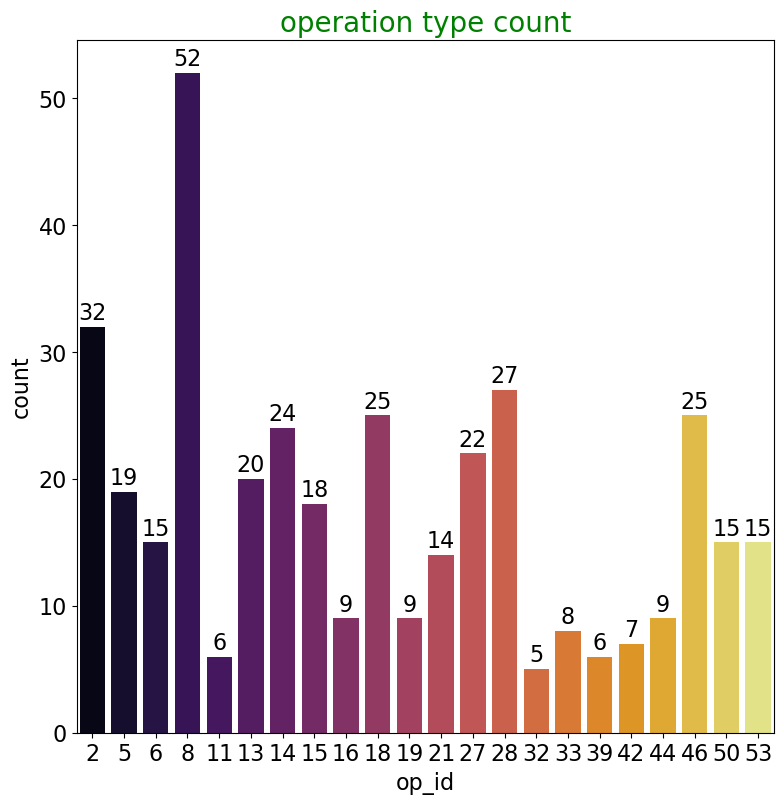

In [222]:
plt.figure(figsize=[9,9])
plot = sns.countplot(df_drop_solo["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.savefig("../../figures/class_and_count_delete_unique_wo_paraphrase.png", bbox_inches='tight')
#plt.xticks(rotation=90)
plt.show()

In [223]:
tr_te_set = df_drop_solo
tr_te_set = tr_te_set.reset_index()
tr_te_set = tr_te_set.drop(columns=["index"])
print(tr_te_set)

     Unnamed: 0                                           Question  \
0            11  what is the cervix cancer mortality rate of wh...   
1            12  what is the lung cancer mortality rate of whit...   
2            13  what are the vote totals of an election for ea...   
3            14  what is the number of arson cases in fort wort...   
4            15               which houses are for sale in utrecht   
..          ...                                                ...   
377         396  which areas are within 3 minutes of the neares...   
378         397  what areas are accessible by car within 3 minu...   
379         398  which areas are accessible within 3 minutes by...   
380         399  which areas are accessible within 3 minutes by...   
381         400  which areas are accessible by car within 3 min...   

                         extents upper level            timespan  \
0               the Western USA          NaN   from 1970 to 1994   
1                the We

# 4. Preprocessing

In [224]:
questions = tr_te_set["Question"].str.lower()
labels = tr_te_set["op_id"]

## 4.1 Remove stopword, lemmartization etc...
 pos tag for stamming <br /> 
 ex) <br /> 
 ***before*** "The striped bats are hanging on their feet for best" -> ['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best'] <br />
 ***after*** "The striped bats are hanging on their feet for best" -> ['The', ***'strip'***, 'bat', ***'be'***, ***'hang'***, 'on', 'their', 'foot', 'for', 'best'] 
 <br />
 <br />
 Also ***delete numbers***, cause those are not that important <br />
 ex) how many buildings are within ***3*** minutes of driving time from fire stations in oleander <br /> -->
 ['how', 'many', 'building', 'be', 'within', 'minute', 'of', 'drive', 'time', 'from', 'fire', 'station', 'in', 'oleander'] <br />
 what are the four fire stations within 3 minutes of travel time from a fire in san francisco <br />
 ['what' 'be' 'the' ***'four'*** 'fire' 'station' 'within' 'unitTime' 'of' 'travel' 'time' 'from' 'a' 'fire' 'in' 'san' 'francisco']

In [225]:
# proccessed vs not processed 비교 해볼 것
# Not Preprocessed
questions_org = [question for question in questions]
# preprocessed
# questions_lem = [preprocess(question) for question in questions]
que_ = questions[5]
lemm = LemmaPlaceTokenizer()
in_ = que_
questions_lem = [" ".join(lemm(question)) for question in questions]
lo_ = 58
print(f"org:{questions_org[lo_]}, \nlem:{questions_lem[lo_]}")


org:what areas are within 500 meters from universities in karbala in iraq, 
lem:what area be within unitN unitL from university in karbala in iraq


## 4.2 Vectorize with TfIdf

In [226]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8',
 stop_words=None,
 )
features = vectorizer.fit_transform(questions_lem).toarray()
features.shape

(382, 332)

# 5. classify

In [227]:
feature_names = vectorizer.get_feature_names_out()
tfidf = pd.DataFrame(features, columns = feature_names)
tfidf_w_question = tfidf.copy()
tfidf_w_question["Question"] = tr_te_set["Question"]
tfidf_w_question["processed_question"] = questions_lem
tfidf_w_question["op_id"] = tr_te_set["op_id"]
tfidf_w_question.to_excel("../../data/processed/tfidf_vectorized_wo_paraphrase.xlsx")

In [228]:
Train_test_df = tfidf_w_question.drop(columns=["Question","processed_question"])
X_train, X_test, y_train, y_test = train_test_split(Train_test_df.drop(columns=["op_id"]),Train_test_df["op_id"], test_size=0.5, stratify=Train_test_df["op_id"], random_state=2215)
print(y_train.info)

<bound method Series.info of 135    32
265    15
273    15
5       2
220     8
       ..
118    27
131    28
370    50
92     16
82     14
Name: op_id, Length: 191, dtype: int64>


/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


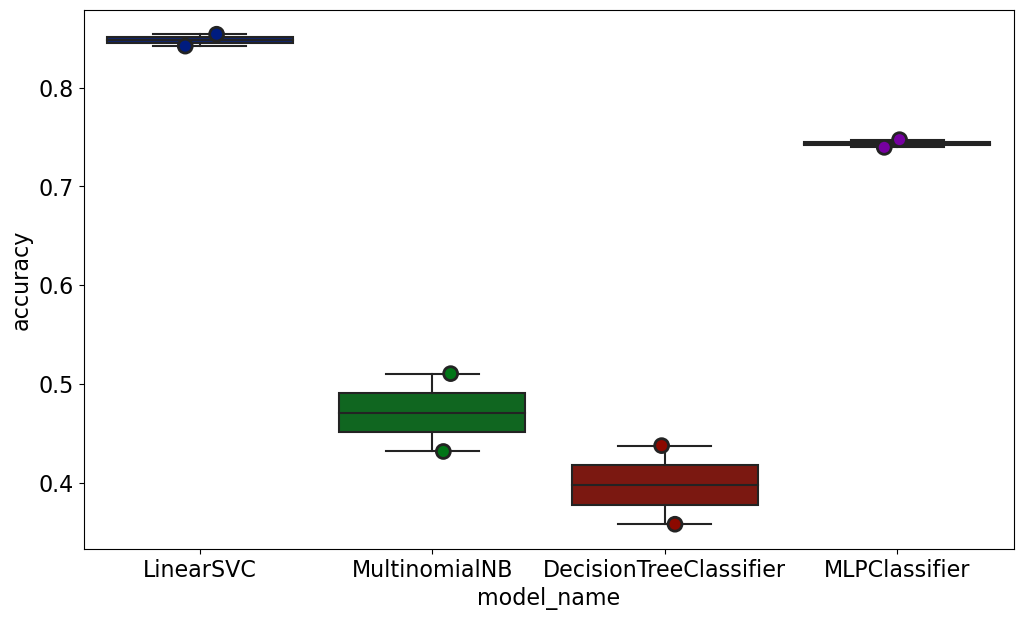

In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

models = [
    LinearSVC(loss = 'hinge'),
    MultinomialNB(),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(activation="logistic",
                solver="adam"),
 
]

CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.figure(figsize=[12,7])
b_plt = sns.boxplot(x='model_name', y='accuracy', data=cv_df, )
s_plt = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.rcParams['font.size'] = "16"
plt.savefig("../../figures/small_classification_wo_paraphrase.png", bbox_inches='tight')
plt.show()

In [230]:
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.397697
LinearSVC                 0.848136
MLPClassifier             0.743476
MultinomialNB             0.470998
Name: accuracy, dtype: float64

# Pick model and run

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[27  2  6 19 44 27  8 14 53 50 46 18 44 53 27 46 50  8 16 27 32  8  2 53
  8  5 28 46 15  5  6  8 53 28  5  8 13 33  6 46 50  5 18 33 21  2 18 11
  5 46 46 21 18  8 14 27  2 27 18  2 21  6  8 13 15 27 44 13 13  8 15 14
 46  8 18 27 18 14 28 27  8 33 18 42 14  8 18 53  8 39  8 28  8  5 46 28
 15 53 46  5 18 27 21  8  8 13  8 50 28 18  8  5 27 13 14 27  8 28 50 50
 53 33 27 50  8  8 39 46 13 53  2 15 53  5 18 19  5 28  8 16 50 46 18 19
 27  8 18 14 46  2 21 14 27 14 13 15 14 19 39 21  6  8 18 44 21 27  6  6
 50 18 27 15 46  6  5  8 28 15 14  5  8 28 27 27 18 18  5  5 14 15 46]
     actual
119      27
0         2
29        6
107      19
344      44
     predict
119       27
0          2
29         6
107       19
344       44
[2, 5, 6, 8, 11, 13, 14, 15, 16, 18, 19, 21, 27, 28, 32, 33, 39, 42, 44, 46, 50, 53]


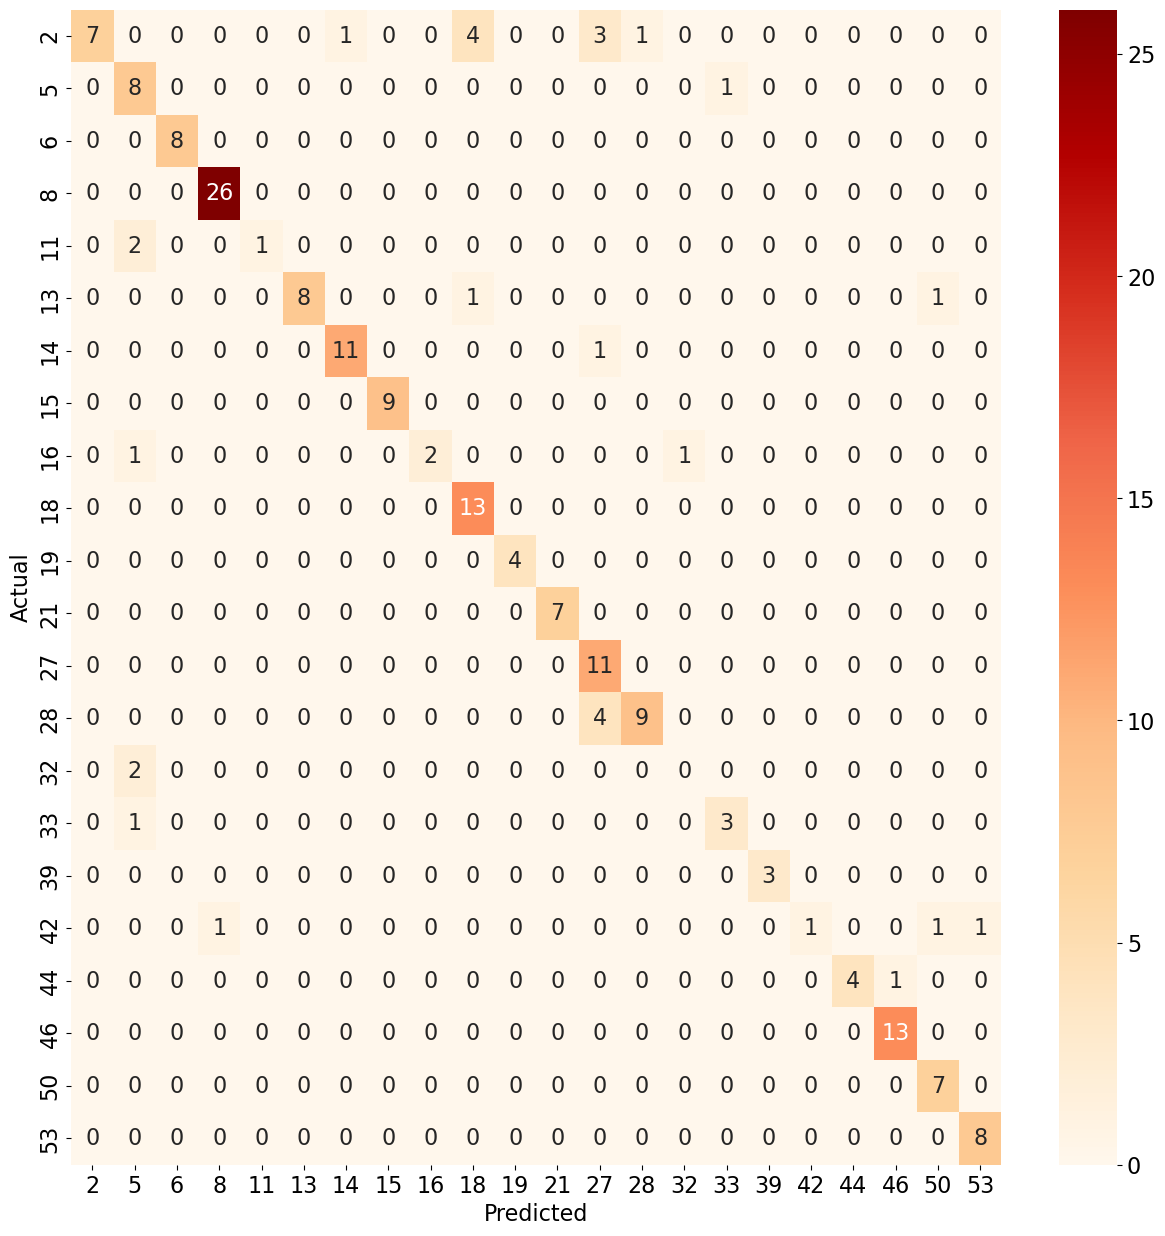

In [231]:
model = LinearSVC(loss = 'hinge', C=2,
random_state=83123)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

questions_df = tfidf_w_question.copy()
questions_df = questions_df.iloc[X_test.index,:]
questions_df = questions_df[["Question","processed_question","op_id"]]
y_test_df = y_test.to_frame(name="actual")
print(y_test_df.head(5))
y_pred_df = pd.DataFrame(y_pred,index=y_test.index,columns=["predict"])
print(y_pred_df.head(5))
questions_df["actual"] = y_test_df
questions_df["predict"] = y_pred_df
questions_df.to_excel("../../data/processed/prediction_vs_actual.xlsx")



from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(sorted(list(set(labels.values))))

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(labels.values))), 
            yticklabels=sorted(list(set(labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../../figures/tfidf_linsvc_wo_paraphrase_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [232]:
from sklearn import metrics

some_key = tfidf_w_question['op_id'].unique().astype('str').tolist()
print(some_key)
print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
report = metrics.classification_report(y_test, y_pred, target_names=some_key, output_dict=True)
report_ = metrics.classification_report(y_test, y_pred, target_names=some_key)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel("../../data/processed/classification_wo_paraphrase_report.xlsx")
print(report_)

['2', '5', '6', '8', '11', '13', '14', '15', '16', '18', '19', '21', '27', '28', '32', '33', '39', '42', '44', '46', '50', '53']
accuracy 0.8534031413612565
              precision    recall  f1-score   support

           2       1.00      0.44      0.61        16
           5       0.57      0.89      0.70         9
           6       1.00      1.00      1.00         8
           8       0.96      1.00      0.98        26
          11       1.00      0.33      0.50         3
          13       1.00      0.80      0.89        10
          14       0.92      0.92      0.92        12
          15       1.00      1.00      1.00         9
          16       1.00      0.50      0.67         4
          18       0.72      1.00      0.84        13
          19       1.00      1.00      1.00         4
          21       1.00      1.00      1.00         7
          27       0.58      1.00      0.73        11
          28       0.90      0.69      0.78        13
          32       0.00      0.0

# Visualize

top 5 keywords per class:
         2          5        6       8         11        13        14  \
0     unitn        the     area    area      spot  scotland     flood   
1      each   distance      not   unitl      rate      wind     house   
2  montinye  euclidean  houston      of     house      farm  oleander   
3       for         to    flood  within       hot        to     urban   
4        me         by       me   unitn  oleander     which        in   

        15        16         18  ...      27       28       32          33  \
0       of  oleander      where  ...  number   median       of  population   
1     bank      each         be  ...    each  tarrant  density     density   
2   branch    patron    utrecht  ...      of    texas    metro        area   
3     fire   library         in  ...     for   county     each        what   
4  station   average  amsterdam  ...  school   census      for        have   

       39       42       44    46      50        53  
0   unitl   

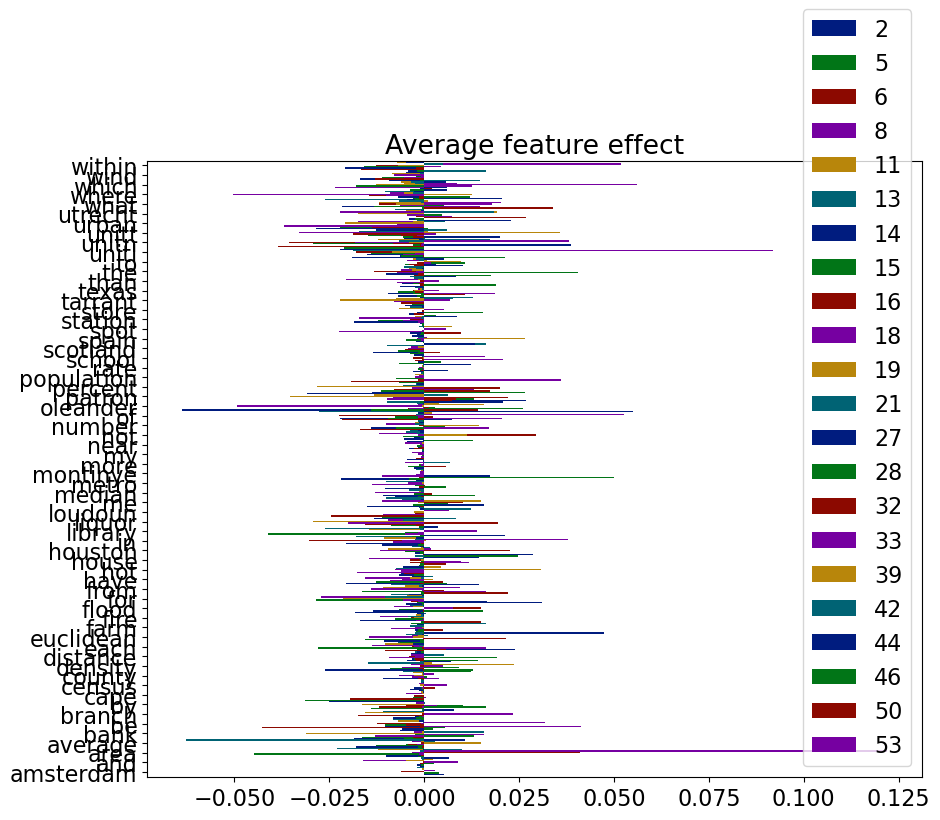

In [233]:
def plot_feature_effects(model, X_train,labels, feature_names):
    average_feature_effects = model.coef_ * np.asarray(X_train.mean(axis=0)).ravel()
    target_names = sorted(list(set(labels.values))) 
    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        top5 = top5.ravel()
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5),axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

        # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)
    ax.set_title("Average feature effect")
    fig.savefig("../../figures/avg_feagure_effect.png", bbox_inches='tight')

    return ax



_ = plot_feature_effects(model, X_train, labels, feature_names)

[    0   405   810  1215  1620  2025  2430  2835  3240  3645  4050  4455
  4860  5265  5670  6075  6480  6885  7290  7695  8100  8505  8910  9315
  9720 10125 10530 10935 11340 11745 12150 12555 12960 13365 13770 14175
 14580 14985 15390 15795 16200 16605 17010 17415 17820 18225 18630 19035
 19440 19845 20250 20655 21060 21465 21870 22275 22680 23085 23490 23895
 24300 24705 25110 25515 25920 26325 26730 27135 27540 27945 28350 28755
 29160 29565 29970 30375 30780 31185 31590 31995 32400 32805 33210 33615
 34020 34425 34830 35235 35640 36045 36450 36855 37260 37665 38070]
top 5 keywords per class:
         2            5        6           8        11        13        14  \
0  montinye    euclidean      not       unitl     spot      wind     flood   
1       pc4     distance  houston        area      hot  scotland     urban   
2      over  measurement     belt       urban   myrtle      farm  accident   
3   country        crime    flood      liquor    crape  shortest     house   
4    

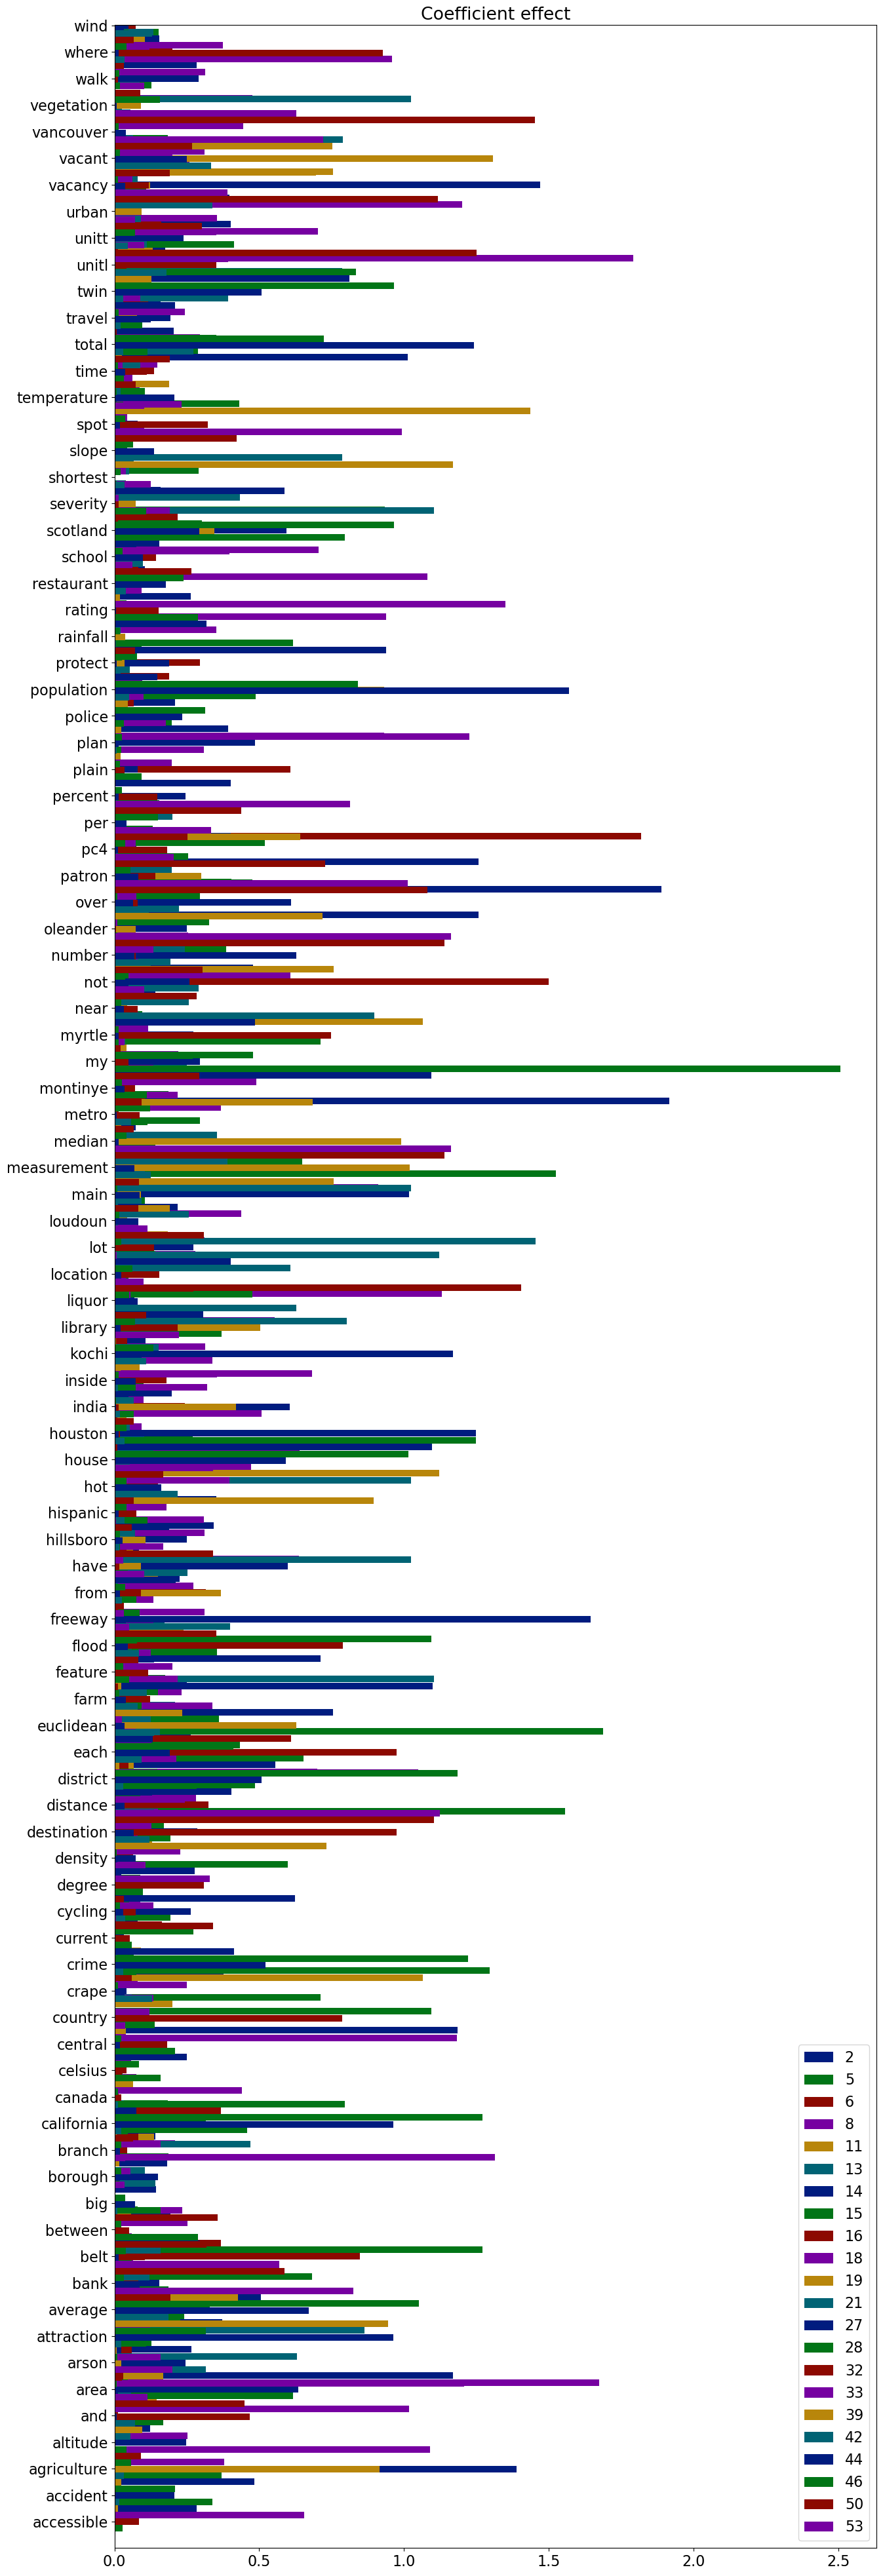

In [234]:
def plot_coef_effects(model, X_train,labels, feature_names):
    coef_effects = np.absolute(model.coef_)
    target_names = sorted(list(set(labels.values))) 
    for i, label in enumerate(target_names):
        top5 = np.argsort(coef_effects[i])[-5:][::-1]
        top5 = top5.ravel()
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5),axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

        # plot feature effects
    bar_size = 100
    padding = 5
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)
    print(y_locs)

    fig, ax = plt.subplots(figsize=(15, 50))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            coef_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)
    ax.set_title("Coefficient effect")
    fig.savefig("../../figures/coef_effect.png", bbox_inches='tight')

    return ax



_ = plot_coef_effects(model, X_train, labels, feature_names)

(22, 332)


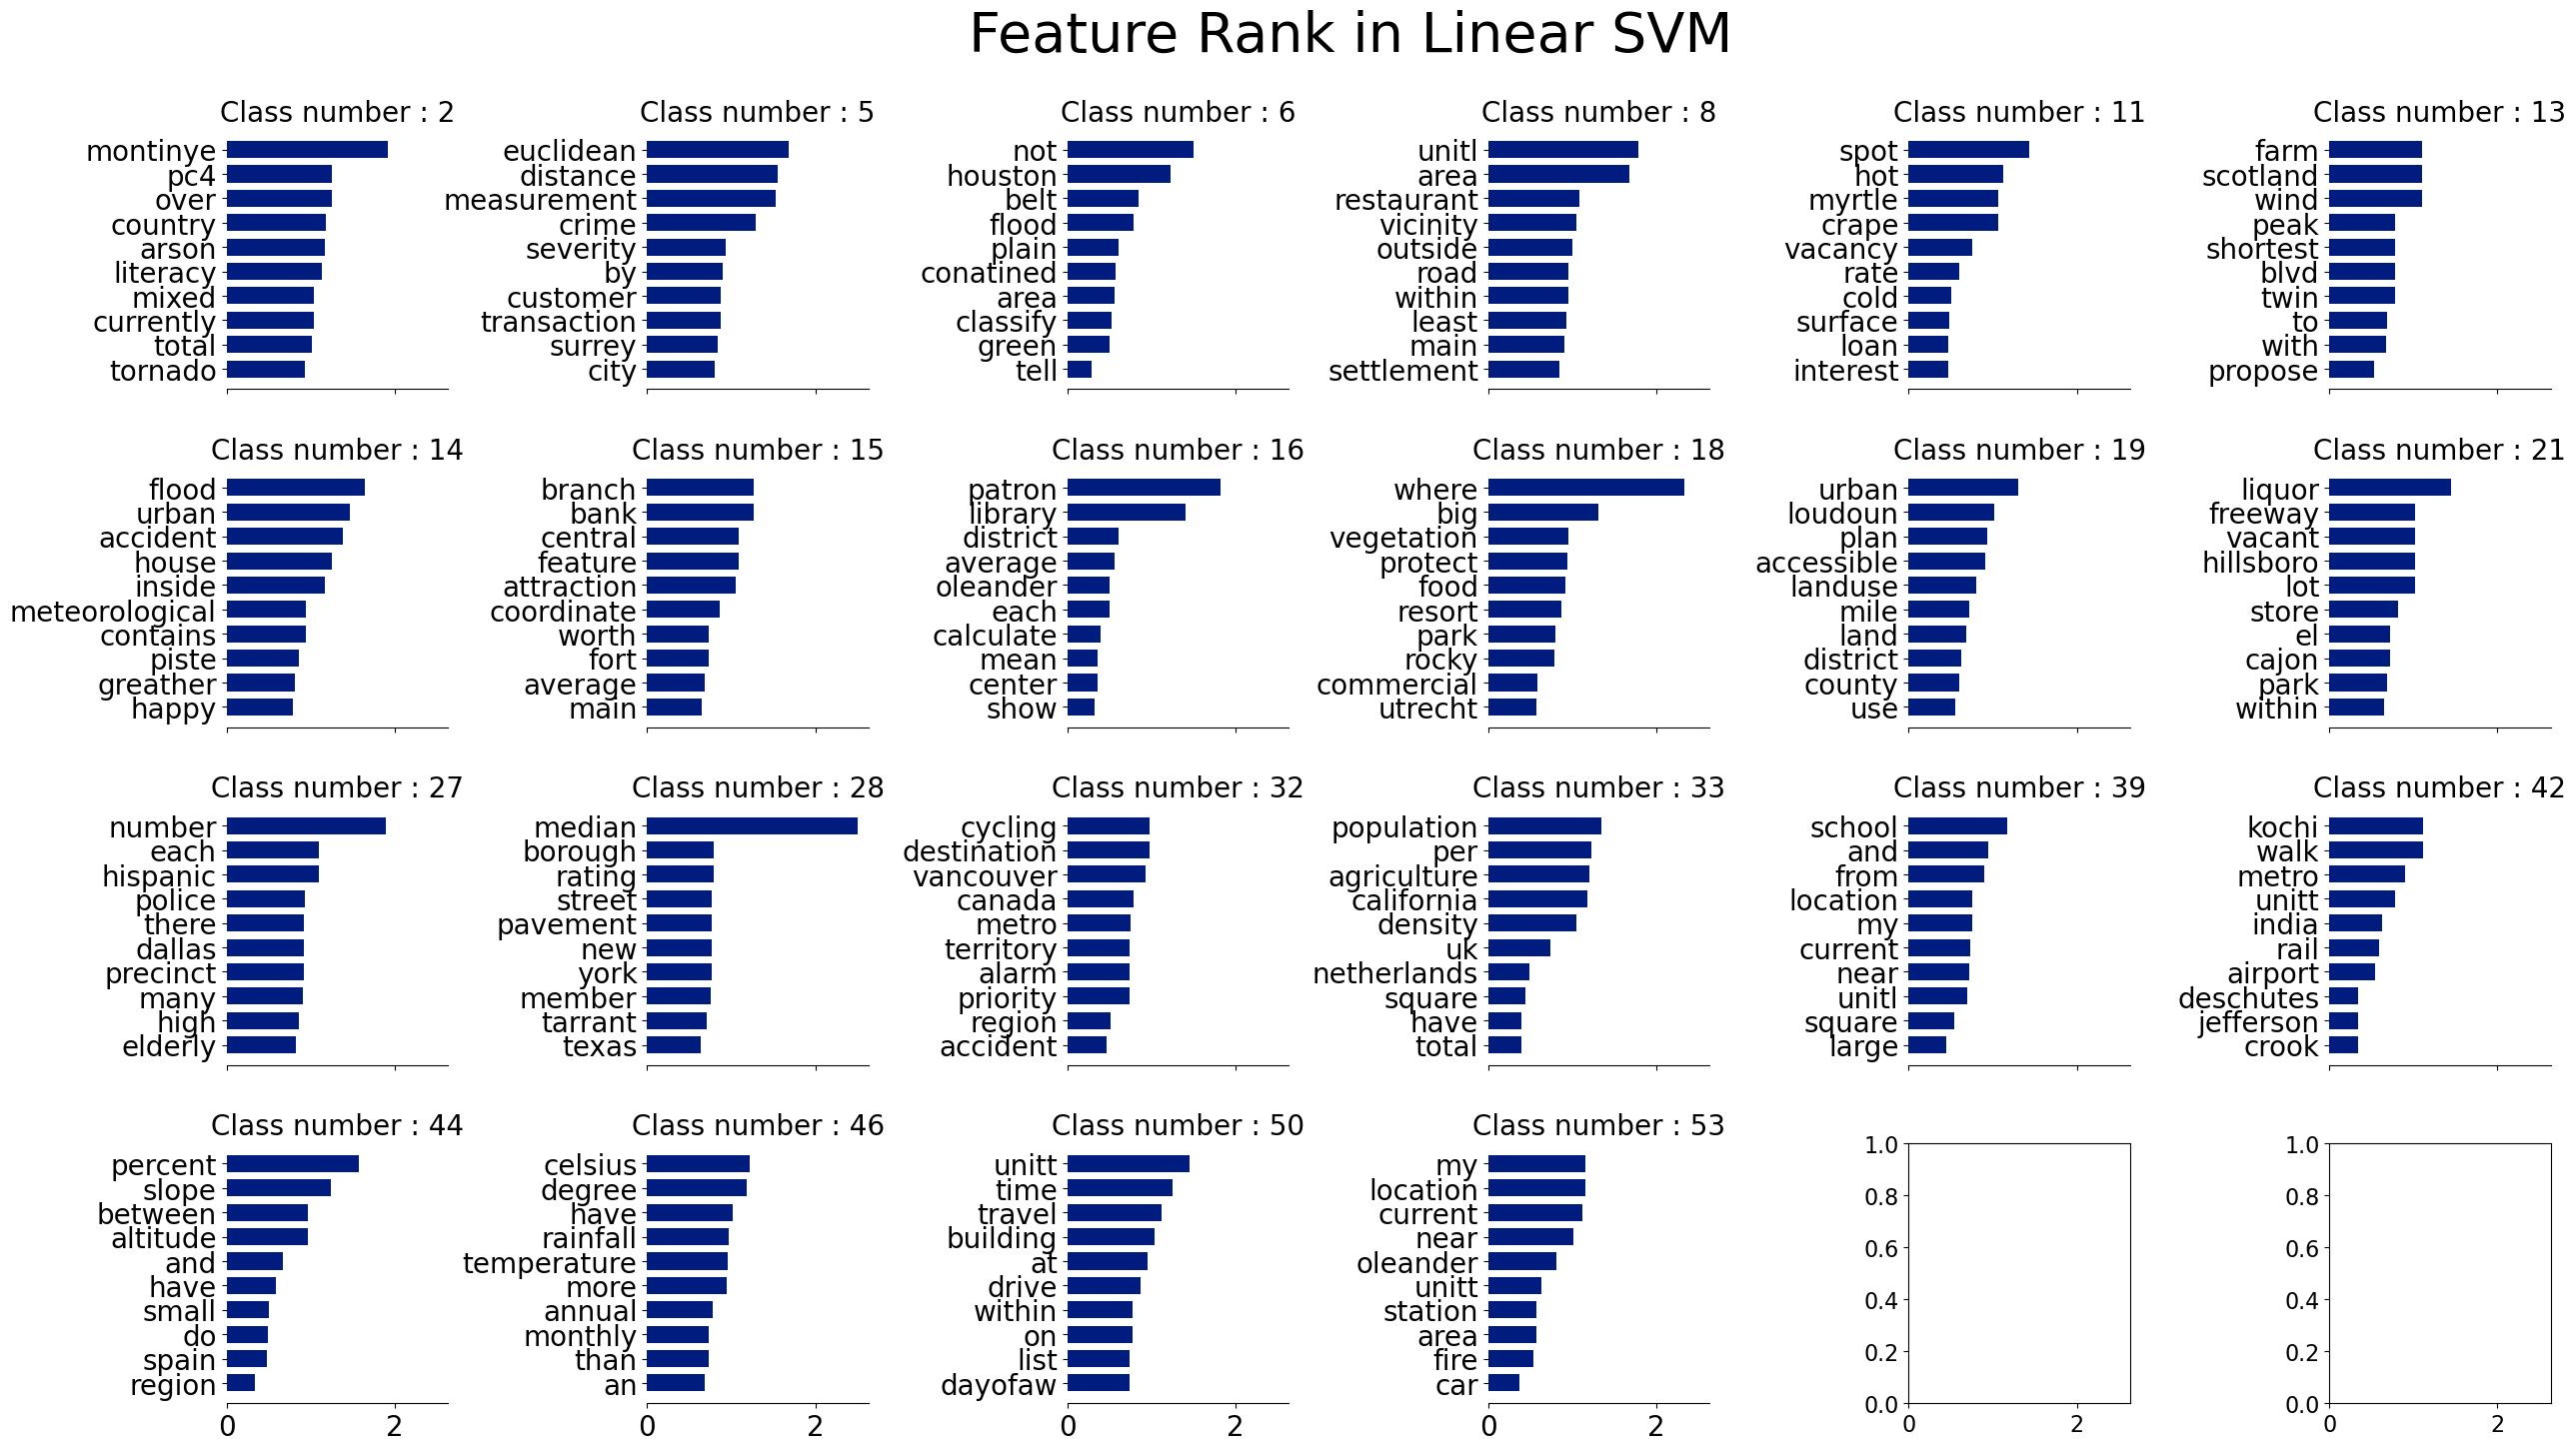

In [235]:
def plot_top_words(isAbs, model, X_train,labels,n_top_words ,feature_names):
    fig_path = "../../figures/feature_rank_abs_in_linear_svm.png"
    coef_effects = np.absolute(model.coef_)
    if isAbs == False:
        fig_path = "../../figures/feature_rank_pos_in_linear_svm.png"
        coef_effects = model.coef_
    target_names = sorted(list(set(labels.values))) 
    plot_rows = 4
    fig, axes = plt.subplots(plot_rows, 
                             coef_effects.shape[0]//plot_rows if coef_effects.shape[0]%plot_rows == 0 else coef_effects.shape[0]//plot_rows + 1,
                              figsize=(30,15), sharex=True)
    axes = axes.flatten()
    print(coef_effects.shape)
    for topic_idx, topic in enumerate(coef_effects):
        top_features_ind = topic.argsort()[:-n_top_words-1:-1]
        top_features = feature_names[top_features_ind]
        class_number = target_names[topic_idx]
        coef_val = topic[top_features_ind]

        ax = axes[topic_idx] 
        ax.barh(top_features, coef_val, height=0.7)
        ax.set_title(f"Class number : {class_number}", fontdict={"fontsize":20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Feature Rank in Linear SVM", fontsize=40)
    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()

    return 


_ = plot_top_words(isAbs=False,model=model, X_train= None,labels=labels, n_top_words=10, feature_names=feature_names)